<a href="https://colab.research.google.com/github/sadra-barikbin/novel-solutions-for-ABSA/blob/main/experiments/Karimi_et_al_2020.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install transformers

In [ ]:
import json
import torch
import torch.nn.functional     as     F
import numpy                   as     np
import matplotlib.pyplot       as     plt
from   tqdm                                         import tqdm
from   torch.utils.data                             import DataLoader, Dataset
from   torch.utils.tensorboard                      import SummaryWriter
from   torch                                        import nn,Tensor
from   transformers                                 import RobertaModel, RobertaTokenizer
from   transformers.models.roberta.modeling_roberta import RobertaLayer,RobertaPooler
from   typing                                       import Tuple,Dict
from   timeit                                       import timeit

In [ ]:
%load_ext tensorboard
%tensorboard --logdir /content/drive/MyDrive/logs

Run the snippet below in the browser console to show the Tensorboard as a separate tab.

```
for(let elem of document.getElementsByTagName('iframe')){
    if( elem.src.includes("tensorboardColab")){
        window.open(elem.src)
        break
    }
}
```

In [ ]:
board = SummaryWriter()

In [ ]:
from tensorboard import notebook
notebook.list() # View open TensorBoard instances
# Control TensorBoard display. If no port is provided, 
# the most recently launched TensorBoard is used
notebook.display(port=6006, height=1000) 

# Data Preparation

In [ ]:
class SentimentClassificationDataset(Dataset):
  def __init__(self, raw_dataset):
    super(SentimentClassificationDataset,self).__init__()
    self.raw_dataset = dict(sorted(raw_dataset.items()))
    self.index_to_id = dict(enumerate(self.raw_dataset))
  def __len__(self):
    return len(self.raw_dataset)

  def __getitem__(self, index) -> Tuple[str, float]:
    item = self.raw_dataset[self.index_to_id[index]]
    target = 2 if item['polarity'] == 'positive' else \
      0 if item['polarity'] == 'negative' else 1
    return item['sentence'], target

## SemEval2016 Restaurant

In [ ]:
train_set = json.load(open("/content/drive/MyDrive/akbar_train.json"))
dev_set   = json.load(open("/content/drive/MyDrive/akbar_dev.json"))
test_set  = json.load(open("/content/drive/MyDrive/akbar_test.json"))

In [ ]:
train_dataset = SentimentClassificationDataset(train_set)
dev_dataset   = SentimentClassificationDataset(dev_set)
test_dataset  = SentimentClassificationDataset(test_set) 

In [ ]:
#Total train data in MB. Later in Accelerated mode, I need to know this stat.
(sum([len(train[x]['sentence'].split()) for x in train])*768*8)/(1024*1024)

355.283203125

# Model Definition

In [ ]:
torch.manual_seed(40)
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')

In [ ]:
class SentimentClassifier(nn.Module):
  def __init__(self):
    super(SentimentClassifier, self).__init__()
    self.roberta = RobertaModel.from_pretrained('roberta-base', output_attentions=False,
                                                add_pooling_layer=False)
    self.cls = nn.ModuleList([ nn.Linear(768,70), nn.ReLU(), nn.Flatten(1, -1),\
                             nn.AdaptiveMaxPool1d(20), nn.Linear(20, 1), nn.Tanh()])

  def forward(self, input: Tensor) -> Tensor:
    embedding = self.roberta(**input).last_hidden_state
    immediate = embedding
    for layer in self.cls:
      immediate = layer(immediate)
    return immediate.squeeze(dim=-1)



In [ ]:
class AkbarSentimentClassifier(nn.Module):
  def __init__(self):
    super(AkbarSentimentClassifier,self).__init__()
    self.roberta = RobertaModel.from_pretrained('roberta-base', output_attentions=False,
                                                add_pooling_layer=False)
    self.novelty = nn.ModuleDict({
        'intermediates' : nn.ModuleList([RobertaLayer(self.roberta.config) for _ in range(4)]),
        'pooler' : RobertaPooler(self.roberta.config),
        'cls' : nn.Linear(768, 3)
    })

  def forward(self,input: Dict[str,Tensor]) -> Tensor:
    roberta_output = self.roberta(**input, output_hidden_states=True)
    logits = []

    # `get_extended_attention_mask` is defined as a method of class `ModuleUtilsMixin`
    # in `modelling_utils.py`  of `transformers` library. `ModuleUtilsMixin` is base class
    # for `PreTrainedModel` class that itself is base class for all library models. When
    # one calls a `RobertaModel` instance on an input, the `get_extended_attention_mask` is
    # automatically called on the intput's `attention_mask`, but if one calls a `RobertaLayer`
    # instance on the same input, the `get_extended_attention_mask` method is not called
    # and an error will be raised, so one should call `get_extended_attention_mask` himself.
    attention_mask = input['attention_mask']
    extended_attn_mask = self.roberta.get_extended_attention_mask(attention_mask,
                                                                  attention_mask.shape,
                                                                  attention_mask.device)
    for i in range(4):
      temp = self.novelty.intermediates[i](roberta_output.hidden_states[-(i+1)], attention_mask=extended_attn_mask)[0]
      pooled = self.novelty.pooler(temp)
      logits.append(self.novelty.cls(pooled))
    return logits

# Train

In [ ]:
model = AkbarSentimentClassifier().cuda()

optimizer_parameter_groups = [
  {'params': list(model.roberta.parameters()),'lr': 1e-5},
  {'params': list(model.novelty.parameters()), 'lr': 1e-3}
]
optimizer = torch.optim.AdamW(optimizer_parameter_groups)

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['roberta.pooler.dense.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.bias', 'roberta.pooler.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
train_history = np.empty((0,2))
dev_history   = np.empty((0,2))
best_loss = np.inf

In [ ]:
model

In [ ]:
train_dataloader = DataLoader(train_dataset, 128, shuffle=True)
dev_dataloader = DataLoader(dev_dataset, 128)

for epoch in tqdm(range(15)):
  model.train()
  batches_stat = []
  for sentence_batch, polarity_batch in train_dataloader:
    encoded_batch = tokenizer.batch_encode_plus(sentence_batch, return_tensors='pt', padding=True)
    encoded_batch = {k: v.cuda() for k, v in encoded_batch.items()}
    polarity_batch = polarity_batch.cuda()
    polarity_one_hot_batch = F.one_hot(polarity_batch, num_classes=3)
    logits_list = model(encoded_batch)
    loss = F.cross_entropy(torch.cat(logits_list),
                           polarity_one_hot_batch.repeat(len(logits_list), 1).float())
    with torch.no_grad():
      logits_avg = torch.stack(logits_list).sum(dim=0) / len(logits_list)
      acc = torch.mean((logits_avg.argmax(dim=1) == polarity_batch).float())
    # Default collate_fn of DataLoader outputs an array of floats as a torch.DoubleTensor
    # loss = F.mse_loss(polarity_prediction_batch, polarity_batch.float().cuda())
    batches_stat.append((loss.item(), acc.item()))
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
  train_history = np.append(train_history, [np.mean(batches_stat, axis=0)], axis=0)
  batches_stat = []
  model.eval()
  for sentence_batch, polarity_batch in dev_dataloader:
    encoded_batch = tokenizer.batch_encode_plus(sentence_batch, return_tensors='pt', padding=True)
    encoded_batch = {k: v.cuda() for k, v in encoded_batch.items()}
    polarity_batch = polarity_batch.cuda()
    polarity_one_hot_batch = F.one_hot(polarity_batch, num_classes=3)
    with torch.no_grad():
      logits_list = model(encoded_batch)
      loss = F.cross_entropy(torch.cat(logits_list),
                           polarity_one_hot_batch.repeat(len(logits_list), 1).float())
      logits_avg = torch.stack(logits_list).sum(dim=0) / len(logits_list)
      acc = torch.mean((logits_avg.argmax(dim=1) == polarity_batch).float())
    batches_stat.append((loss.item(), acc.item()))
  epoch_stat = np.mean(batches_stat, axis=0)
  epoch_mean_loss = epoch_stat[0]
  if epoch_mean_loss < best_loss:
    best_loss = epoch_mean_loss
    torch.save(model.state_dict(),'/content/drive/MyDrive/akbar.pt')
  dev_history = np.append(dev_history, [epoch_stat], axis=0) 

100%|██████████| 15/15 [07:36<00:00, 30.45s/it]


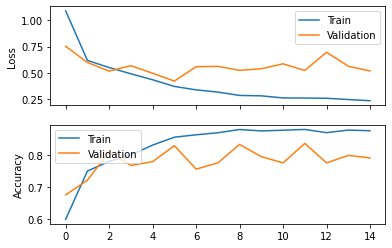

In [ ]:
_, axes = plt.subplots(2, 1, sharex=True)
axes[0].plot(train_history[:, 0])
axes[0].plot(dev_history[:, 0])
axes[0].set_ylabel('Loss')
axes[0].legend(['Train', 'Validation'], loc='upper right')
axes[1].plot(train_history[:, 1])
axes[1].plot(dev_history[:, 1])
axes[1].set_ylabel('Accuracy')
axes[1].legend(['Train', 'Validation'], loc='upper left')

# Test

In [ ]:
test_dataloader = DataLoader(test_dataset, 128)
true_preds = 0.
batches_loss = []
model.eval()
for sentence_batch, polarity_batch in test_dataloader:
  encoded_batch = tokenizer.batch_encode_plus(sentence_batch, return_tensors='pt', padding=True)
  encoded_batch = {k: v.cuda() for k, v in encoded_batch.items()}
  polarity_batch = polarity_batch.cuda()
  polarity_one_hot_batch = F.one_hot(polarity_batch, num_classes=3)
  with torch.no_grad():
    logits_list = model(encoded_batch)
    loss = F.cross_entropy(torch.cat(logits_list),
                          polarity_one_hot_batch.repeat(len(logits_list), 1).float())
    logits_avg = torch.stack(logits_list).sum(dim=0) / len(logits_list)
    true_preds += torch.sum(logits_avg.argmax(dim=1) == polarity_batch).item()
  batches_loss.append(loss.item())
print(f"Accuracy: {true_preds/len(test_dataset)*100:.2f}% Loss: {np.mean(batches_loss):.2f}")

Accuracy: 82.05% Loss: 0.68
